# Chemical-Disease Relation (CDR) Tutorial

In this example, we'll be writing an application to extract *mentions of* **chemical-induced-disease relationships** from Pubmed abstracts, as per the [BioCreative CDR Challenge](http://www.biocreative.org/resources/corpora/biocreative-v-cdr-corpus/).  This tutorial will show off some of the more advanced features of Snorkel, so we'll assume you've followed the Intro tutorial.

Let's start by reloading from the last notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession

session = SnorkelSession()

In [2]:
from snorkel.models import candidate_subclass

ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

train_cands = session.query(ChemicalDisease).filter(ChemicalDisease.split == 0).all()
dev_cands = session.query(ChemicalDisease).filter(ChemicalDisease.split == 1).all()

# Part III: Writing LFs

This tutorial features some more advanced LFs than the intro tutorial, with more focus on distant supervision and dependencies between LFs.

### Distant supervision approaches

We'll use the [Comparative Toxicogenomics Database](http://ctdbase.org/) (CTD) for distant supervision. The CTD lists chemical-condition entity pairs under three categories: therapy, marker, and unspecified. Therapy means the chemical treats the condition, marker means the chemical is typically present with the condition, and unspecified is...unspecified. We can write LFs based on these categories.

In [3]:
import bz2
from six.moves.cPickle import load

with bz2.BZ2File('data/ctd.pkl.bz2', 'rb') as ctd_f:
    ctd_unspecified, ctd_therapy, ctd_marker = load(ctd_f)

In [4]:
def cand_in_ctd_unspecified(c):
    return 1 if c.get_cids() in ctd_unspecified else 0

def cand_in_ctd_therapy(c):
    return 1 if c.get_cids() in ctd_therapy else 0

def cand_in_ctd_marker(c):
    return 1 if c.get_cids() in ctd_marker else 0

In [5]:
def LF_in_ctd_unspecified(c):
    return -1 * cand_in_ctd_unspecified(c)

def LF_in_ctd_therapy(c):
    return -1 * cand_in_ctd_therapy(c)

def LF_in_ctd_marker(c):
    return cand_in_ctd_marker(c)

### Text pattern approaches

Now we'll use some LF helpers to create LFs based on indicative text patterns. We came up with these rules by using the viewer to examine training candidates and noting frequent patterns.

In [6]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'

def LF_induce(c):
    return 1 if re.search(r'{{A}}.{0,20}induc.{0,20}{{B}}', get_tagged_text(c), flags=re.I) else 0

causal_past = ['induced', 'caused', 'due']
def LF_d_induced_by_c(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + '.{0,9}(by|to).{0,50}', 1)
def LF_d_induced_by_c_tight(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + ' (by|to) ', 1)

def LF_induce_name(c):
    return 1 if 'induc' in c.chemical.get_span().lower() else 0     

causal = ['cause[sd]?', 'induce[sd]?', 'associated with']
def LF_c_cause_d(c):
    return 1 if (
        re.search(r'{{A}}.{0,50} ' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)
        and not re.search('{{A}}.{0,50}(not|no).{0,20}' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)
    ) else 0

treat = ['treat', 'effective', 'prevent', 'resistant', 'slow', 'promise', 'therap']
def LF_d_treat_c(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1)
def LF_c_treat_d(c):
    return rule_regex_search_btw_AB(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1)
def LF_treat_d(c):
    return rule_regex_search_before_B(c, ltp(treat) + '.{0,50}', -1)
def LF_c_treat_d_wide(c):
    return rule_regex_search_btw_AB(c, '.{0,200}' + ltp(treat) + '.{0,200}', -1)

def LF_c_d(c):
    return 1 if ('{{A}} {{B}}' in get_tagged_text(c)) else 0

def LF_c_induced_d(c):
    return 1 if (
        ('{{A}} {{B}}' in get_tagged_text(c)) and 
        (('-induc' in c[0].get_span().lower()) or ('-assoc' in c[0].get_span().lower()))
        ) else 0

def LF_improve_before_disease(c):
    return rule_regex_search_before_B(c, 'improv.*', -1)

pat_terms = ['in a patient with ', 'in patients with']
def LF_in_patient_with(c):
    return -1 if re.search(ltp(pat_terms) + '{{B}}', get_tagged_text(c), flags=re.I) else 0

uncertain = ['combin', 'possible', 'unlikely']
def LF_uncertain(c):
    return rule_regex_search_before_A(c, ltp(uncertain) + '.*', -1)

def LF_induced_other(c):
    return rule_regex_search_tagged_text(c, '{{A}}.{20,1000}-induced {{B}}', -1)

def LF_far_c_d(c):
    return rule_regex_search_btw_AB(c, '.{100,5000}', -1)

def LF_far_d_c(c):
    return rule_regex_search_btw_BA(c, '.{100,5000}', -1)

def LF_risk_d(c):
    return rule_regex_search_before_B(c, 'risk of ', 1)

def LF_develop_d_following_c(c):
    return 1 if re.search(r'develop.{0,25}{{B}}.{0,25}following.{0,25}{{A}}', get_tagged_text(c), flags=re.I) else 0

procedure, following = ['inject', 'administrat'], ['following']
def LF_d_following_c(c):
    return 1 if re.search('{{B}}.{0,50}' + ltp(following) + '.{0,20}{{A}}.{0,50}' + ltp(procedure), get_tagged_text(c), flags=re.I) else 0

def LF_measure(c):
    return -1 if re.search('measur.{0,75}{{A}}', get_tagged_text(c), flags=re.I) else 0

def LF_level(c):
    return -1 if re.search('{{A}}.{0,25} level', get_tagged_text(c), flags=re.I) else 0

def LF_neg_d(c):
    return -1 if re.search('(none|not|no) .{0,25}{{B}}', get_tagged_text(c), flags=re.I) else 0

WEAK_PHRASES = ['none', 'although', 'was carried out', 'was conducted',
                'seems', 'suggests', 'risk', 'implicated',
               'the aim', 'to (investigate|assess|study)']

WEAK_RGX = r'|'.join(WEAK_PHRASES)

def LF_weak_assertions(c):
    return -1 if re.search(WEAK_RGX, get_tagged_text(c), flags=re.I) else 0

### Composite LFs

The following LFs take some of the strongest distant supervision and text pattern LFs, and combine them to form more specific LFs. These LFs introduce some obvious dependencies within the LF set, which we will model later.

In [7]:
def LF_ctd_marker_c_d(c):
    return LF_c_d(c) * cand_in_ctd_marker(c)

def LF_ctd_marker_induce(c):
    return (LF_c_induced_d(c) or LF_d_induced_by_c_tight(c)) * cand_in_ctd_marker(c)

def LF_ctd_therapy_treat(c):
    return LF_c_treat_d_wide(c) * cand_in_ctd_therapy(c)

def LF_ctd_unspecified_treat(c):
    return LF_c_treat_d_wide(c) * cand_in_ctd_unspecified(c)

def LF_ctd_unspecified_induce(c):
    return (LF_c_induced_d(c) or LF_d_induced_by_c_tight(c)) * cand_in_ctd_unspecified(c)

### Rules based on context hierarchy

These last two rules will make use of the context hierarchy. The first checks if there is a chemical mention much closer to the candidate's disease mention than the candidate's chemical mention. The second does the analog for diseases.

In [8]:
def LF_closer_chem(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find chemical closer than @dist/2 in either direction
    sent = c.get_parent()
    closest_other_chem = float('inf')
    for i in range(dis_end, min(len(sent.words), dis_end + dist // 2)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return -1
    for i in range(max(0, dis_start - dist // 2), dis_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return -1
    return 0

def LF_closer_dis(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find chemical disease than @dist/8 in either direction
    sent = c.get_parent()
    for i in range(chem_end, min(len(sent.words), chem_end + dist // 8)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Disease' and cid != sent.entity_cids[dis_start]:
            return -1
    for i in range(max(0, chem_start - dist // 8), chem_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Disease' and cid != sent.entity_cids[dis_start]:
            return -1
    return 0

### Running the LFs on the training set

In [9]:
LFs = [
    LF_c_cause_d,
    LF_c_d,
    LF_c_induced_d,
    LF_c_treat_d,
    LF_c_treat_d_wide,
    LF_closer_chem,
    LF_closer_dis,
    LF_ctd_marker_c_d,
    LF_ctd_marker_induce,
    LF_ctd_therapy_treat,
    LF_ctd_unspecified_treat,
    LF_ctd_unspecified_induce,
    LF_d_following_c,
    LF_d_induced_by_c,
    LF_d_induced_by_c_tight,
    LF_d_treat_c,
    LF_develop_d_following_c,
    LF_far_c_d,
    LF_far_d_c,
    LF_improve_before_disease,
    LF_in_ctd_therapy,
    LF_in_ctd_marker,
    LF_in_patient_with,
    LF_induce,
    LF_induce_name,
    LF_induced_other,
    LF_level,
    LF_measure,
    LF_neg_d,
    LF_risk_d,
    LF_treat_d,
    LF_uncertain,
    LF_weak_assertions,
]

In [10]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [11]:
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 57.3 s, sys: 965 ms, total: 58.3 s
Wall time: 1min 6s


<8439x33 sparse matrix of type '<class 'numpy.int64'>'
	with 17454 stored elements in Compressed Sparse Row format>

In [13]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_c_cause_d,0,0.031639,0.027965,0.012679
LF_c_d,1,0.021804,0.018130,0.005806
LF_c_induced_d,2,0.004147,0.004147,0.001896
LF_c_treat_d,3,0.047636,0.047636,0.019908
LF_c_treat_d_wide,4,0.088518,0.087451,0.037801
LF_closer_chem,5,0.188411,0.169570,0.091717
LF_closer_dis,6,0.014931,0.014220,0.009006
LF_ctd_marker_c_d,7,0.017656,0.017656,0.005451
LF_ctd_marker_induce,8,0.020382,0.020382,0.008058
LF_ctd_therapy_treat,9,0.047162,0.047162,0.017301


# Part IV: Training the generative model

As mentioned above, we want to include the dependencies between our LFs when training the generative model. Snorkel makes it easy to do this! `DependencySelector` runs a fast structure learning algorithm over the matrix of LF outputs to identify a set of likely dependencies. We can see that these match up with our prior knowledge. For example, it identified a "reinforcing" dependency between `LF_c_induced_d` and `LF_ctd_marker_induce`. Recall that we constructed the latter using the former.

In [14]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
len(deps)

250

Now we'll train the generative model, using the `deps` argument to account for the learned dependencies. We'll also model LF propensity here, unlike the intro tutorial. In addition to learning the accuracies of the LFs, this also learns their likelihood of labeling an example.

In [15]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(
    L_train, deps=deps, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0
)

Inferred cardinality: 2


In [16]:
train_marginals = gen_model.marginals(L_train)

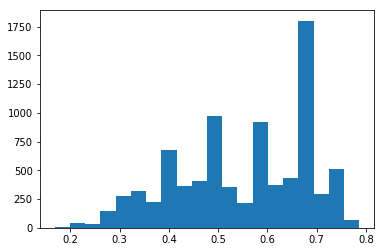

In [17]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [49]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.417582,0.0091,0.442857,0.006134
1,0.389610,0.0077,0.333333,0.003759
2,0.387755,0.0049,0.391304,0.003562
3,0.542169,0.0166,0.530000,0.010487
4,0.560748,0.0214,0.596639,0.014048
5,0.614746,0.0963,0.632135,0.059161
6,0.392157,0.0051,0.404255,0.003759
7,0.465753,0.0073,0.448276,0.005144
8,0.463768,0.0069,0.440000,0.004353
9,0.571429,0.0161,0.540230,0.009300


In [50]:
gen_model.learned_lf_stats()['Accuracy']

/anaconda/envs/snorkel/lib/python3.6/site-packages/snorkel/learning/gen_learning.py:348: RuntimeWarning: invalid value encountered in double_scalars
  "Precision": tp / (tp + fp),
/anaconda/envs/snorkel/lib/python3.6/site-packages/snorkel/learning/gen_learning.py:350: RuntimeWarning: invalid value encountered in double_scalars
  "Accuracy": (tp + tn) / coverage,


0     0.543478
1     0.447368
2     0.750000
3     0.549180
4     0.565421
5     0.606506
6     0.500000
7     0.428571
8     0.382353
9     0.532787
10    0.551136
11    0.428571
12    1.000000
13    0.636364
14    0.521739
15    0.555556
16    1.000000
17    0.406250
18    0.552632
19    0.500000
20    0.583889
21    0.670499
22    0.400000
23    0.596154
24    0.666667
25    0.500000
26    0.714286
27         NaN
28    0.620690
29    0.250000
30    0.368421
31    0.666667
32    0.555556
Name: Accuracy, dtype: float64

In [19]:
from snorkel.annotations import save_marginals
save_marginals(session, L_train, train_marginals)

Saved 8439 marginals


### Checking performance against development set labels

Finally, we'll run the labeler on the development set, load in some external labels, then evaluate the LF performance. The external labels are applied via a small script for convenience. It maps the document-level relation annotations found in the CDR file to mention-level labels. Note that these will not be perfect, although they are pretty good. If we wanted to keep iterating, we could use `snorkel.lf_helpers.test_LF` against the dev set, or look at some false positive and false negative candidates.

In [20]:
from load_external_annotations import load_external_labels
load_external_labels(session, ChemicalDisease, split=1, annotator='gold')

AnnotatorLabels created: 920


In [21]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

<920x1 sparse matrix of type '<class 'numpy.int64'>'
	with 920 stored elements in Compressed Sparse Row format>

In [22]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [23]:
_ = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.895
Neg. class accuracy: 0.617
Precision            0.538
Recall               0.895
F1                   0.672
----------------------------------------
TP: 274 | FP: 235 | TN: 379 | FN: 32



In [24]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

/anaconda/envs/snorkel/lib/python3.6/site-packages/snorkel/learning/gen_learning.py:348: RuntimeWarning: invalid value encountered in double_scalars
  "Precision": tp / (tp + fp),
/anaconda/envs/snorkel/lib/python3.6/site-packages/snorkel/learning/gen_learning.py:350: RuntimeWarning: invalid value encountered in double_scalars
  "Accuracy": (tp + tn) / coverage,
/anaconda/envs/snorkel/lib/python3.6/site-packages/snorkel/annotations.py:137: RuntimeWarning: invalid value encountered in true_divide
  ac = (tp+tn) / (tp+tn+fp+fn)


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_c_cause_d,0,0.034783,0.033696,0.011957,22,10,0,0,0.687500,0.441860
LF_c_d,1,0.020652,0.018478,0.003261,11,8,0,0,0.578947,0.500000
LF_c_induced_d,2,0.002174,0.002174,0.000000,1,1,0,0,0.500000,0.200000
LF_c_treat_d,3,0.031522,0.031522,0.017391,0,0,9,20,0.689655,0.511111
LF_c_treat_d_wide,4,0.077174,0.076087,0.042391,0,0,17,54,0.760563,0.537778
LF_closer_chem,5,0.205435,0.191304,0.125000,0,0,55,134,0.708995,0.595188
LF_closer_dis,6,0.010870,0.010870,0.006522,0,0,2,8,0.800000,0.555556
LF_ctd_marker_c_d,7,0.018478,0.018478,0.003261,11,6,0,0,0.647059,0.409091
LF_ctd_marker_induce,8,0.018478,0.018478,0.006522,12,5,0,0,0.705882,0.500000
LF_ctd_therapy_treat,9,0.041304,0.041304,0.027174,0,0,8,30,0.789474,0.424000


In [25]:
dev_marginals = gen_model.marginals(L_dev)
dev_marginals.shape

(920,)

In [77]:
def lf_vs_gen_vs_disc(L, L_fns, gt, gen_labels, disc_labels, show_examples=False):
    """ Computes metrics comparing labeling functions, generative model, and discriminative model.
    
    Note: shows in 'red' text LFs for which LFs preform better than the disc. model.
    """
    
    results = {}
    for lf_label, lf in zip(L, L_fns):
        
        # LF correct but generative model wrong
        lf_over_gen = np.logical_and(gen_labels != gt, lf_label == gt)
        num_lf_over_gen = np.sum(lf_over_gen)

        # compute num correct when the LF has assigned a label in {-1, 1}
        not_abstained_idx = np.where(lf_label != 0)[0]
        num_labeled_by_lf = len(not_abstained_idx) # denominator
        
        lf_correct = np.sum((lf_label == gt)[not_abstained_idx])
        gen_correct = np.sum((gen_labels == gt)[not_abstained_idx])
        disc_correct = np.sum((gen_labels == gt)[not_abstained_idx])
        

        if (num_labeled_by_lf > 0) :
            results[lf.__name__]= {
                'idx': not_abstained_idx,
                'lf_label': lf_label,
                'num_labeled_by_lf': num_labeled_by_lf,
                'lf_over_gen_score': num_lf_over_gen / num_labeled_by_lf,
                'lf_score': lf_correct / num_labeled_by_lf,
                'gen_score': gen_correct / num_labeled_by_lf,
                'disc_score': disc_correct / num_labeled_by_lf
            }

    # pring overall scores
    sorted_dict = sorted(results.items(), key=lambda kv: kv[1]['lf_score'] - kv[1]['gen_score'], reverse=True)
    for k,v in sorted_dict:
        print ('--- %s (%d labeled) --- ' % (k,v['num_labeled_by_lf']))
        to_print = 'LF: %.4f, Gen: %.4f, Disc: %.4f' % (v['lf_score'], v['gen_score'], v['disc_score'])
        if v['lf_score'] > v['gen_score']:
            print("\x1b[31m%s\x1b[0m" % (to_print))
        else:
            print (to_print)
        
        if show_examples:
            for idx in v['idx']:
                c = dev_cands[idx]
                sent = c.get_parent()
                print ('GT:', gt[idx], 'LF:', v['lf_label'][idx], 'Gen:', gen_labels[idx])
                print (c)
                print (sent)
                print ('-')

    
# convert marginals to hard labels
lf_vs_gen_vs_disc(
    L=L_dev.toarray().T, 
    L_fns=LFs,
    gt=np.squeeze(L_gold_dev.toarray()),
    gen_labels=2 * (dev_marginals > 0.5) - 1,
    disc_labels = np.load('lstm_preds.npy')
)

--- LF_improve_before_disease (7 labeled) --- 
LF: 0.8571, Gen: 0.4286, Disc: 0.4286
--- LF_uncertain (25 labeled) --- 
LF: 0.9200, Gen: 0.5600, Disc: 0.5600
--- LF_closer_dis (10 labeled) --- 
LF: 0.8000, Gen: 0.6000, Disc: 0.6000
--- LF_ctd_therapy_treat (38 labeled) --- 
LF: 0.7895, Gen: 0.6053, Disc: 0.6053
--- LF_treat_d (12 labeled) --- 
LF: 0.9167, Gen: 0.7500, Disc: 0.7500
--- LF_induced_other (31 labeled) --- 
LF: 0.9032, Gen: 0.7742, Disc: 0.7742
--- LF_level (18 labeled) --- 
LF: 0.6667, Gen: 0.5556, Disc: 0.5556
--- LF_far_c_d (132 labeled) --- 
LF: 0.7803, Gen: 0.6742, Disc: 0.6742
--- LF_d_induced_by_c (33 labeled) --- 
LF: 0.7273, Gen: 0.6667, Disc: 0.6667
--- LF_c_treat_d_wide (71 labeled) --- 
LF: 0.7606, Gen: 0.7042, Disc: 0.7042
--- LF_closer_chem (189 labeled) --- 
LF: 0.7090, Gen: 0.6878, Disc: 0.6878
--- LF_c_cause_d (32 labeled) --- 
LF: 0.6875, Gen: 0.6875, Disc: 0.6875
--- LF_c_d (19 labeled) --- 
LF: 0.5789, Gen: 0.5789, Disc: 0.5789
--- LF_c_induced_d (2 labe